In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
from datetime import datetime
import plotly.express as px
import itertools
from pylab import rcParams
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv       dataframe_flow_variable_60min.csv
dataframe_dma_flow_60min.csv    DMA_225.csv
dataframe_flow_1D.csv           DMA_468.csv
dataframe_flow_variable_1D.csv  persistence_results.pkl


In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )
data_DMA225 = data[['Date_time','DMA_225']]

In [5]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()

hourly_data.isnull().sum().sum()
hourly_data.isna().sum().sum()
data_hourly = hourly_data.values

In [6]:
#Train and test split
#split = 1059
##train = data_hourly[:7008]

##test = data_hourly[7008:]

In [7]:
#Train and test split
split = 1059
train = data_hourly[:-1059]
test = data_hourly[-1059:]

In [8]:
train.shape

(7701, 1)

In [9]:
test.shape

(1059, 1)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [11]:
def data_preparation(array_dataset, look_back=1, future=1, index=0):
    features = array_dataset.shape[1]
    arr_X, arr_Y = [], []
    if len(array_dataset) - look_back <= 0:
        arr_X.append(array_dataset)
    else:
        for i in range(len(array_dataset) - look_back - future):
            arr_Y.append(array_dataset[(i + look_back), index])
            arr_X.append(array_dataset[i:(i + look_back)])
    arr_X, arr_Y = np.array(arr_X), np.array(arr_Y)
    arr_X = np.reshape(arr_X, (arr_X.shape[0], look_back, features))
    return arr_X, arr_Y

look_back = 24
features = 1
X_train, Y_train = data_preparation(train_scaled, look_back=24, future=24, index=0)
X_test, Y_test = data_preparation(test_scaled, look_back=24, future=24, index=0)

In [12]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape( (X_test.shape[0],X_test.shape[1],1))

In [13]:
print('X_train shape:',X_train.shape)
print('Y_train shape:',Y_train.shape)
print('X_test shape:',X_test.shape)
print('Y_test shape:',Y_test.shape)

X_train shape: (7653, 24, 1)
Y_train shape: (7653,)
X_test shape: (1011, 24, 1)
Y_test shape: (1011,)


In [14]:
model2 = tf.keras.Sequential()
model2.add(LSTM(80, input_shape=(look_back,features)))
#model2.add(Dropout(0.2))
#model2.add(LSTM(80));
model2.add(Dense(80))
model2.add(Dense(100))
#model2.add(Dense(150));
#model2.add(Dense(80))
model2.add(Dense(24))
optimizer = tf.keras.optimizers.Adam(lr=0.09,decay=0.90);
model2.compile(loss='mae', optimizer=optimizer, metrics=['accuracy'])
#history=model.fit(X_train1, Y_train1, validation_data=(X_test1,Y_test1),shuffle=False, epochs=100, batch_size=1, verbose=2)
history2=model2.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=300,batch_size=300)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/300
26/26 [==============================] - 5s 102ms/step - loss: 6.9234 - accuracy: 0.0000e+00 - val_loss: 0.8920 - val_accuracy: 9.8912e-04
Epoch 2/300
26/26 [==============================] - 2s 88ms/step - loss: 0.2498 - accuracy: 1.3067e-04 - val_loss: 0.7865 - val_accuracy: 9.8912e-04
Epoch 3/300
26/26 [==============================] - 2s 74ms/step - loss: 0.0639 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_accuracy: 9.8912e-04
Epoch 4/300
26/26 [==============================] - 2s 78ms/step - loss: 0.0371 - accuracy: 0.0000e+00 - val_loss: 0.4268 - val_accuracy: 9.8912e-04
Epoch 5/300
26/26 [==============================] - 2s 78ms/step - loss: 0.0302 - accuracy: 0.0000e+00 - val_loss: 0.3550 - val_accuracy: 9.8912e-04
Epoch 6/300
26/26 [==============================] - 2s 76ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - val_loss: 0.3132 - val_accuracy: 9.8912e-04
Epoch 7/300
26/26 [==============================] - 2s 88ms/step - loss: 0.0252 - accuracy: 0.0000

In [15]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

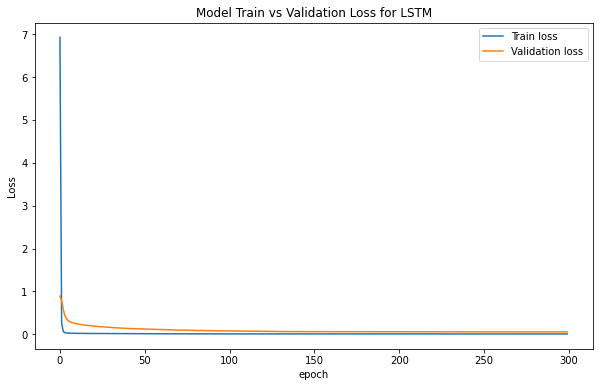

In [16]:
plot_loss(history2,'LSTM')

In [17]:
# Generate predictions
train_pred = model2.predict(X_train)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model2.predict(X_test)

In [18]:
# De-standardising the output to original value
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([Y_train])
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([Y_test])
predictions = test_pred

In [19]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0]))
final_data = pd.DataFrame((y_test[0]))
#final_data = pd.DataFrame((Y_test))
final_data.rename(columns = {0:'original_value'}, inplace = True)
final_data['predicted_value'] = lstm_df

In [20]:
import math
from sklearn.metrics import mean_squared_error
testset = math.sqrt(mean_squared_error(final_data['original_value'], final_data['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  1.4367194408319681


In [21]:
final_df2= hourly_data.reset_index()
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model2.predict(X_test)]
y = [y for y in Y_test]
# Creating the frame to store both predictions
days = final_df2[['Date_time']].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_data], axis=1, join='inner')

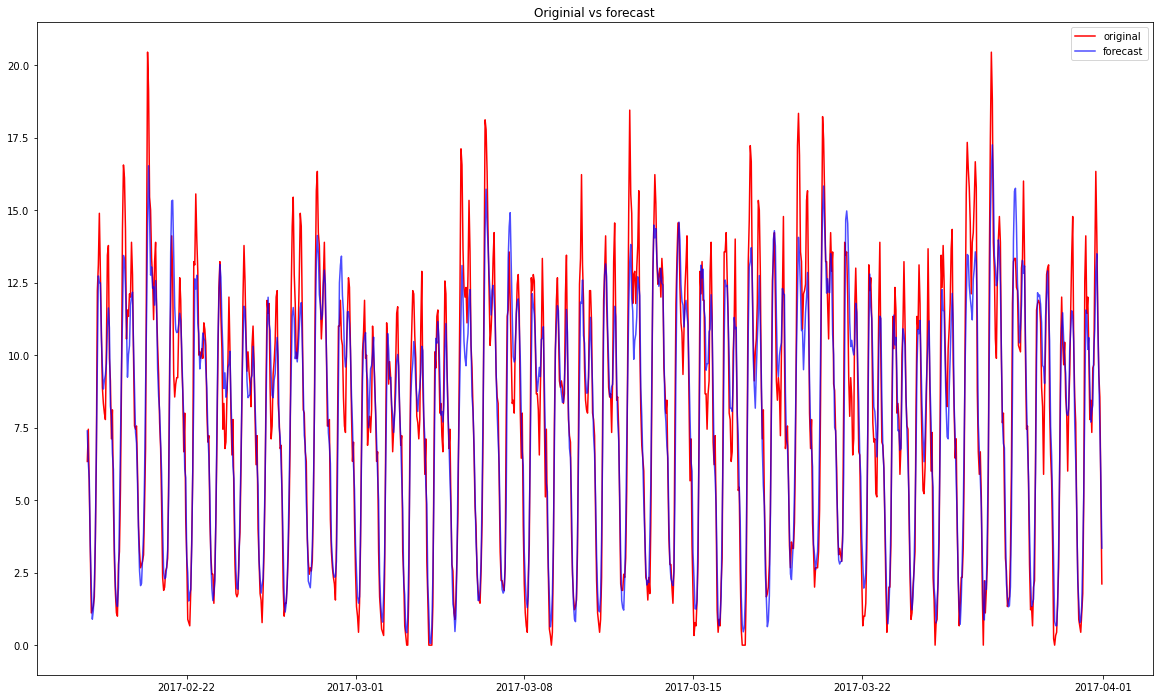

In [22]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [23]:
df.to_csv('raw_data.csv', index=False)
df.to_excel('raw_data.xls', index=False)

In [24]:
from google.colab import files

# e.g. save pandas output as csv
result.to_csv('DMA_225_ULSTM_modified.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('DMA_225_ULSTM_modified.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>